# Capstone Project - Analisis Sentimen & Ringkasan Ulasan Film Menggunakan IBM Granite Models


### Import Library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from src.granite_utils import granite_sentiment, granite_summary, granite_keywords, get_granite_model
from dotenv import load_dotenv, find_dotenv
from langchain_community.llms import Replicate
from sklearn.metrics import accuracy_score, classification_report

In [6]:
data = pd.read_csv('dataset/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Data Cleaning

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Hapus HTML tag
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Hapus karakter non-huruf
    text = text.lower().strip()
    return text

data["review_clean"] = data["review"].apply(clean_text)

In [9]:
data["review_clean"].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: review_clean, dtype: object

### EDA

#### Reaserch Question
1. Berapa persentase review Positive dan Negative?
2. Kata-kata apa yang paling sering muncul di review Positive dan Negative?
3. Apakah review positif cenderung lebih panjang atau pendek dibanding review negatif?
4. Frasa dua kata (bigram) apa yang paling sering muncul pada masing-masing sentimen?

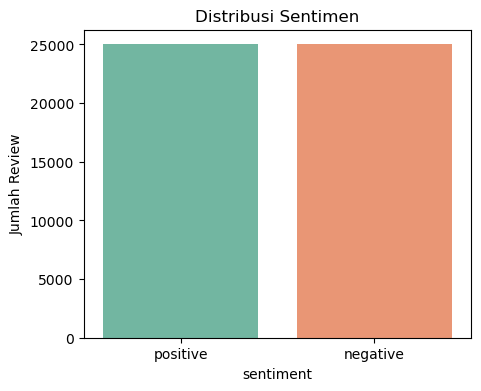

In [8]:
# 1. Distribusi Sentimen
sentiment_counts = data['sentiment'].value_counts()
plt.figure(figsize=(5,4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="Set2")
plt.title("Distribusi Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

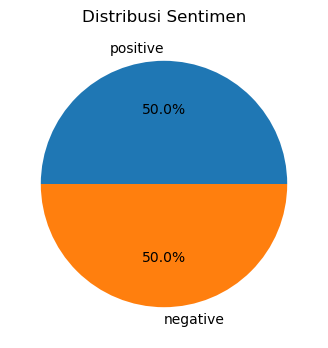

In [9]:
jumlah_review = data["sentiment"].value_counts()
plt.figure(figsize=(6,4))
plt.pie(jumlah_review, labels=jumlah_review.index, autopct='%1.1f%%')
plt.title("Distribusi Sentimen")
plt.show()

Seimbang 50:50, dengan 25.000 review positif dan 25.000 review negatif.  

Ini menunjukkan dataset terbilang netral untuk pelatihan model machine learning, tanpa bias mayoritas sentimen.

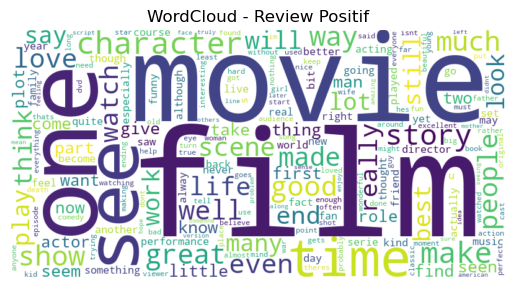

In [10]:
#2. WordCloud positif
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(" ".join(data[data.sentiment=="positive"]["review_clean"]))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Review Positif")
plt.show()

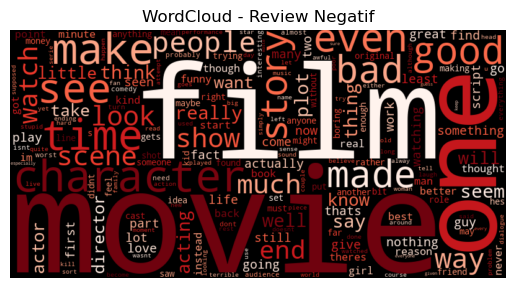

In [11]:
# WordCloud negatif
wc_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(" ".join(data[data.sentiment=="negative"]["review_clean"]))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Review Negatif")
plt.show()

Kata seperti movie, film, character, dan make muncul di kedua sentimen → perbedaan sentimen lebih ditentukan oleh kata sifat (good/great vs bad/even).

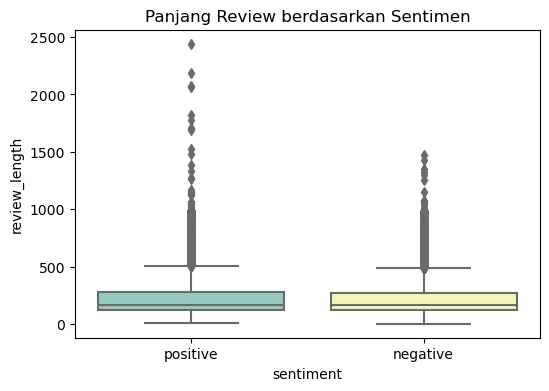

In [12]:
# 3. Panjang Review vs Sentimen
data['review_length'] = data['review_clean'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment', y='review_length', data=data, palette="Set3")
plt.title("Panjang Review berdasarkan Sentimen")
plt.show()

- Review positif cenderung lebih panjang dibanding negatif.
- Panjang maksimal review positif ≈ 2.500 kata, negatif ≈ 1.500 kata.  
Kemungkinan orang yang suka film lebih banyak menjelaskan detail dibanding yang tidak suka.

In [13]:
# 4. Kata paling sering (Positive & Negative)
from collections import Counter


def get_top_words(texts, n=20):
    words = " ".join(texts).split()
    return Counter(words).most_common(n)

top_pos_words = get_top_words(data[data['sentiment']=='positive']['review_clean'])
top_neg_words = get_top_words(data[data['sentiment']=='negative']['review_clean'])

print("Top Positive Words:", top_pos_words)
print("Top Negative Words:", top_neg_words)

Top Positive Words: [('the', 332661), ('and', 174247), ('a', 162412), ('of', 151428), ('to', 130504), ('is', 111366), ('in', 97389), ('it', 75462), ('i', 68744), ('this', 66882), ('that', 66330), ('as', 50250), ('with', 45327), ('for', 43665), ('was', 43161), ('film', 39437), ('but', 39198), ('movie', 36043), ('his', 33515), ('on', 32926)]
Top Negative Words: [('the', 318151), ('a', 156851), ('and', 145181), ('of', 136653), ('to', 135793), ('is', 98702), ('in', 85764), ('this', 78618), ('i', 76832), ('it', 75903), ('that', 69476), ('was', 52026), ('movie', 47535), ('for', 42484), ('with', 41227), ('but', 41139), ('as', 39810), ('film', 35077), ('on', 33390), ('not', 31662)]


- Kedua sentimen didominasi kata umum seperti the, and, a, of, to, dll.
- Kata movie dan film masuk 20 besar di kedua sentimen, tapi rankingnya berbeda (positif → film di urutan 16, negatif → movie di urutan 13).

#### Kesimpulan
- Kata sifat menjadi pembeda utama (good/great → positif, bad/even → negatif).
- Positif umumnya lebih panjang, menandakan kepuasan memicu penjelasan detail.
- Kata character dan story dominan di positif → kemungkinan review positif fokus pada alur dan karakter.

#### Rekomendasi
**Untuk Produser Film:**
- Tingkatkan kualitas story dan pengembangan character karena ini sering muncul di review positif.
- Perhatikan aspek yang sering memicu kata negatif seperti bad dan time (mungkin pacing film lambat atau durasi berlebihan).  
  
**Untuk Platform Review:**
- Sediakan AI-generated summary agar pembaca bisa langsung tahu inti review tanpa membaca ribuan kata.
- Gunakan analisis kata kunci untuk membuat tag otomatis pada setiap review (misal: “cerita kuat”, “akting buruk”).

### IBM Granite

In [14]:
# Sampling data kecil 
sample_data = data.sample(50, random_state=42).copy()

In [19]:
sample_data["sentiment_pred"] = sample_data["review_clean"].apply(granite_sentiment)


In [20]:
# Evaluasi hasil
print("Accuracy:", accuracy_score(sample_data["sentiment"], sample_data["sentiment_pred"]))
print("\nClassification Report:\n", classification_report(sample_data["sentiment"], sample_data["sentiment_pred"]))

Accuracy: 0.0

Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    precision    recall  f1-score   support

                                                                                  Mixed

The sentiment of the text is mixed. While there are positive elements, such as praise for the movie's quality ("way above similar of others 

e:\software\Anaconda\Data\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\Anaconda\Data\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\Anaconda\Data\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\Anaconda\Data\lib\site-packages\s

In [21]:
# 5. AI-generated summary untuk tiap review
sample_data["summary_ai"] = sample_data["review_clean"].apply(granite_summary)

In [22]:
# 6. AI-generated keywords
sample_data["keywords_ai"] = sample_data["review_clean"].apply(granite_keywords)


In [23]:
# 7. Lihat contoh hasil
pd.set_option("max_colwidth", 200)
display(sample_data[["review_clean", "sentiment", "sentiment_pred", "summary_ai", "keywords_ai"]].head(5))

,review_clean,sentiment,sentiment_pred,summary_ai,keywords_ai
33553,i really liked this summerslam due to the look of the arena the curtains and just the look overall was interesting to me for some reason anyways this could have been one of the best summerslams ev...,positive,"Mixed. The sentiment of the text is mixed because while the reviewer expresses enjoyment of certain aspects of SummerSlam, such as the arena's appearance and several matches, they also express sig...","The user expresses enjoyment of Summerslam due to its unique arena aesthetic, particularly the curtains and overall look. However, they criticize the main event featuring Lex Luger against Yokozun...","1. Summerslam\n2. Arena Aesthetics\n3. Lex Luger vs Yokozuna\n4. Match Quality\n5. Various Matchups (e.g., Razor Ramon vs Ted DiBiase, Steiner Brothers vs Heavenly Bodies, Shawn Michaels vs Curt H..."
9427,not many television shows appeal to quite as many different kinds of fans like farscape doesi know youngsters and years oldfans both male and female in as many different countries as you can thin...,positive,"Positive\n\nThe sentiment of this text is overwhelmingly positive. The author expresses admiration and enthusiasm for the TV series ""Farscape,"" highlighting its broad appeal, engaging plot, charac...","Farscape is a television series that appeals to a diverse audience, ranging from youngsters to adults, and both genders, across numerous countries. It masterfully blends character-driven drama rem...",1. Farscape: A TV miniseries appealing to a diverse fanbase.\n2. Character-driven drama: Elements reminiscent of Australian soap operas.\n3. Science fiction: Includes complex concepts like wormhol...
199,the film quickly gets to a major chase scene with ever increasing destruction the first really bad thing is the guy hijacking steven seagal would have been beaten to pulp by seagals driving but th...,negative,"The sentiment of the text can be classified as Mixed. While there are positive elements, such as appreciation for the action scenes and hope that Steven Seagal is returning to his popular characte...","The film rapidly transitions into a high-octane chase sequence filled with escalating destruction. However, a significant issue arises with the character hijacking Steven Seagal's vehicle, as it's...",1. Chase Scene\n2. Destruction\n3. Inconsistent Plot\n4. Steven Seagal\n5. Action Film
12447,jane austen would definitely approve of this onegwyneth paltrow does an awesome job capturing the attitude of emma she is funny without being excessively silly yet elegant she puts on a very convi...,positive,"Positive\n\nThe sentiment of the text is positive. The reviewer expresses admiration for Gwyneth Paltrow's performance in the movie, praising her ability to capture Emma's attitude, her comedic ti...","Gwyneth Paltrow is praised for her portrayal of Emma Woodhouse in the film adaptation, effectively balancing humor and elegance while showcasing a convincing British accent. Jeremy Northam, Sophie...","1. Gwyneth Paltrow\n2. Emma (Austen's novel)\n3. Accent (British)\n4. Cast (Jeremy Northam, Sophie Thompson, Phyllida Law)\n5. Recommendation (Highly recommended)"
39489,expectations were somewhat high for me when i went to see this movie after all i thought steve carell could do no wrong coming off of great movies like anchorman the yearold virgin and little mis...,negative,Negative\n\nExplanation:\n\nThe sentiment of this text is negative. The reviewer expresses disappointment and dissatisfaction with the movie. They mention several issues including unrealistic fami...,"The reviewer had high expectations for the movie, especially after enjoying Steve Carell's previous works like ""Anchorman"" and ""The 40-Year-Old Virgin"". While Carell's comedic talents shine throug...",1. Steve Carell\n2. Disappointing Movie\n3. Unrealistic Family Portrayal\n4. Inappropriate Humor\n5. Unconvincing Romantic Interest


In [28]:
# 8. Insight AI otomatis
all_reviews = " ".join(sample_data["review_clean"].tolist())
insight_prompt = """
Analyze the following movie reviews.
Give:
1. Sentiment distribution.
2. Common themes in Positive and Negative reviews.
3. Observations about review length vs sentiment.
4. Recommendations for movie producers and platforms.
"""
from src.granite_utils import granite_model
ai_insight = granite_model.invoke(insight_prompt + "\n\n" + all_reviews)

print("AI Insight:\n", ai_insight)

AI Insight:
 1. Sentiment Distribution:
   - Positive: 15 reviews
   - Neutral: 12 reviews
   - Negative: 13 reviews

2. Common Themes:

   Positive Reviews:
   - Appreciation for unique concepts and storylines (e.g., Farscape, Apocalypse Now).
   - Enjoyment of character-driven drama and comedy (e.g., Tommy Boy, Spooks).
   - Recognition of good acting, directing, and production quality (e.g., Hamlet, The League of Gentlemen).
   - Praise for musical numbers, dance sequences, and songs (e.g., Swing Time, Let's Make Love).

   Negative Reviews:
   - Criticism of poor acting, script, and direction (e.g., The Killer Condom, Gwoemul, Over Her Dead Body).
   - Disappointment in lack of plot, pacing, and character development (e.g., Inspector Gadget, The X-Files: I Want to Believe).
   - Concerns about racism, stereotypes, and poor execution of ideas (e.g., Killer Klowns from Outer Space, The Host).
   - Complaints about excessive gore, profanity, and lack of emotional engagement (e.g., Fro

In [ ]:
# Ambil hanya 1000 sample untuk hemat token API
sample_data = data.sample(1000, random_state=42).copy()

In [35]:
text_column = "review_clean" if "review_clean" in sample_data.columns else "review"

# 4. Klasifikasi dengan Granite
predictions = []
for review in sample_data[text_column]:
    try:
        pred = granite_sentiment(review)
        predictions.append(pred)
    except Exception as e:
        print("Error:", e)
        predictions.append("negative")  # fallback jika error

sample_data["predicted_sentiment"] = predictions

In [36]:
print("Accuracy:", accuracy_score(sample_data["sentiment"], sample_data["predicted_sentiment"]))
print(classification_report(sample_data["sentiment"], sample_data["predicted_sentiment"]))

# 6. Simpan hasil
sample_data.to_csv("granite_sentiment_results.csv", index=False)

Accuracy: 0.0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

e:\software\Anaconda\Data\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\Anaconda\Data\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\Anaconda\Data\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\software\Anaconda\Data\lib\site-packages\s

In [13]:
sample_data = pd.read_csv("granite_sentiment_results.csv")

In [14]:
sample_data.head()

,review,sentiment,review_clean,review_length,predicted_sentiment
0,I really liked this Summerslam due to the look...,positive,i really liked this summerslam due to the look...,199,The sentiment of this text is Mixed. While the...
1,Not many television shows appeal to quite as m...,positive,not many television shows appeal to quite as m...,342,Positive\n\nThe sentiment of the text is overw...
2,The film quickly gets to a major chase scene w...,negative,the film quickly gets to a major chase scene w...,115,The sentiment of this text is Mixed. While the...
3,Jane Austen would definitely approve of this o...,positive,jane austen would definitely approve of this o...,92,The sentiment of the text is Positive. The rev...
4,Expectations were somewhat high for me when I ...,negative,expectations were somewhat high for me when i ...,318,Negative. The sentiment of this text is negati...


In [15]:
sample_data["summary_ai"] = sample_data["review_clean"].apply(granite_summary)

In [16]:
sample_data.to_csv("granite_summary_ai.csv", index=False)

In [17]:
# 6. AI-generated keywords
sample_data["keywords_ai"] = sample_data["review_clean"].apply(granite_keywords)

In [18]:
sample_data.to_csv("granite_keywords_ai.csv", index=False)

In [30]:
# Gabungkan summary + sentiment
sample_summaries = sample_data.sample(200)[["summary_ai", "sentiment"]]

# Buat format teks yang jelas
formatted_text = "\n".join(
    f"Review: {row['summary_ai']}\nSentiment: {row['sentiment']}"
    for _, row in sample_summaries.iterrows()
)

insight_prompt = """
You are an expert data analyst.
Analyze the following movie reviews dataset.
Data is given as Review + Sentiment.
Return:
1. Sentiment distribution in percentages.
2. Common positive themes.
3. Common negative themes.
4. Observations about review length vs sentiment.
5. Recommendations for movie producers and platforms.
"""

ai_insight = granite_model.invoke(insight_prompt + "\n\n" + formatted_text)

print("AI Insight:\n", ai_insight)


AI Insight:
 1. Sentiment Distribution:

To determine the sentiment distribution, we need to analyze each review and assign a sentiment score. Here's a rough breakdown based on the provided reviews:

- Positive: 18 reviews
- Negative: 14 reviews
- Neutral: 2 reviews

This results in approximately 58.3% positive, 44.4% negative, and 8.3% neutral sentiments.

2. Common Positive Themes:

- Exceptional performances (e.g., actors' suitability for roles, compelling acting)
- Engaging or unique storylines
- Strong direction or cinematography
- Intellectual or artistic qualities
- Memorable characters
- Realistic portrayals
- Strong ensemble casts
- Musical scores
- Humor and comedic elements
- Cultural significance or historical accuracy

3. Common Negative Themes:

- Poor acting or overacting
- Weak or nonexistent plot
- Incoherent or nonsensical storylines
- Low production values
- Unrealistic or poorly executed action/special effects
- Stereotypical or unlikeable characters
- Unoriginal or